<IPython.core.display.Javascript object>


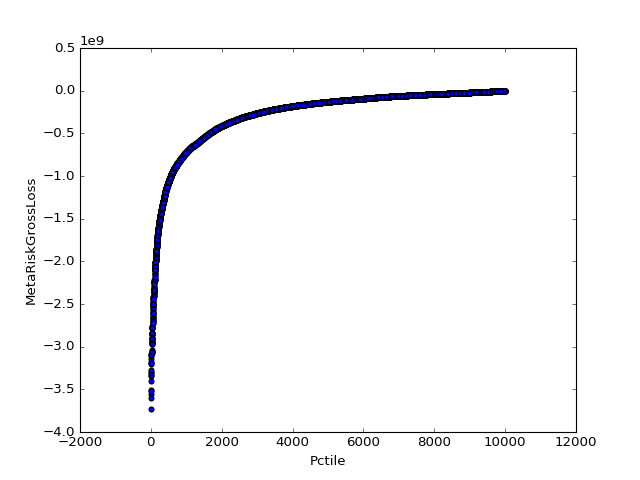

In [8]:
%matplotlib notebook

import os
import urllib
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
#import com.databricks.spark.avro
from pyspark import SparkContext
from pyspark import SparkConf
from functools import reduce  # For Python 3.x
from pyspark.sql import DataFrame, SQLContext

#conf = SparkConf().setAppName("building a warehouse")
#sc = SparkContext(conf=conf)
#sqlCtx = SQLContext(sc)

deals_df = sqlCtx.read.csv("adl://optimumcadence.azuredatalakestore.net/data/NAH/meta/deals.csv", header=True)

metarisks_df = sqlCtx.read.csv("adl://optimumcadence.azuredatalakestore.net/data/NAH/meta/metarisks.csv", header = True)

#zipped_deals = spark.read.csv("data//zipped//sub", header=False)
# #zipped_deals = spark.read.format("com.databricks.spark.avro").load("data//avro")
zipped_deals = sqlCtx.read.parquet("adl://optimumcadence.azuredatalakestore.net/data/NAH/calculator/*/*.parquet")

# ##old_columns = zipped_deals.schema.names


zipped_df = zipped_deals.toDF("EventSetId","PerilId","GeoId","LOBId","EventId","Simulation","EventDay","EventIsSynthetic","NthEvent","LayerAttrition","ReinstatementAttrition")
#num_deals = zipped_df.select("EventSetId").distinct().count()
#pprint("Num of deals: {num}".format(num=num_deals))

# #zipped_df.write.partitionBy("EventSetId").format("com.databricks.spark.avro").save("data//avro")
# #zipped_df.write.parquet('data//parq')

all_event_sets = zipped_df
metarisks_df.createOrReplaceTempView("metarisks")
all_event_sets.createOrReplaceTempView("df")
deals_df.createOrReplaceTempView("deals")

elt_query = """
SELECT Simulation,EventId, EventDay,
SUM(deals.Limit * (CASE deals.TransactionType WHEN 'B' THEN 1 ELSE -1 END) *df.LayerAttrition
) as MetaRiskGrossLoss
,SUM(deals.Limit *(CASE deals.TransactionType WHEN 'B' THEN 1 ELSE -1 END) *(df.LayerAttrition - deals.ROL * df.ReinstatementAttrition)
) as MetaRiskLoss
,SUM(deals.Limit *(CASE deals.TransactionType WHEN 'B' THEN -1 ELSE 1 END) * deals.ROL * df.ReinstatementAttrition
) as MetaRiskReinstatementPremium , MetaRiskId FROM df 
INNER JOIN deals ON deals.EventSetId = df.EventSetId 
INNER JOIN metarisks ON metarisks.PerilId = df.PerilId 
AND metarisks.GeoId = df.GeoId WHERE metarisks.MetaRiskId = 51
GROUP BY Simulation, metarisks.MetaRiskId, EventId,EventDay
"""

df_elt = sqlCtx.sql(elt_query)
#df_elt.write.parquet("data//output//real")
df_collect_elt = df_elt.toPandas()

df_ylt = df_collect_elt.groupby('Simulation')['MetaRiskGrossLoss', 'MetaRiskLoss'].sum()

#df_ylt.describe().show()
df_ylt["Pctile"] = df_ylt.MetaRiskGrossLoss.rank()

df_ylt.sort_values("Pctile").head(1000)

df_ylt.plot(x='Pctile', y='MetaRiskGrossLoss', kind='scatter')

